In [1]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
import os
import pandas as pd
from math import isnan
import random
import glob
import sys
sys.path.append('../')
from package_global_functions import *

extSSDpath = getExternalSSDpath()
if os.path.exists(extSSDpath):
    resPath = extSSDpath + getProjectFoldername() + '/gillespie_sim_ci_Reina/results'
else:
    resPath = '/results'
    print('Forgot the SSD!!!!!')


# Stationary probability distributions

0.08000000000000003 0.1163895
0.9199999999999998 0.6874947880434781
------
0.36000000000000004 0.04534230555555557
0.6400000000000009 0.7761797421875
------
0.4 0.05829402500000001
0.6000000000000012 0.765562075
------


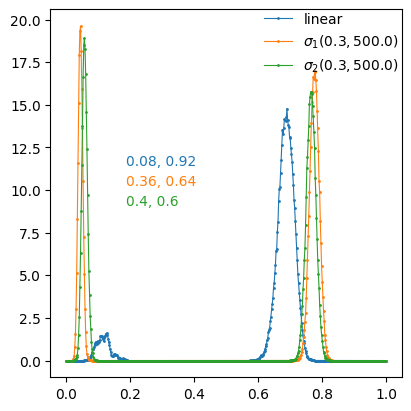

In [4]:
qs, noiseType, noise = [1.0, 1.05], 1, 0.25
N, ic = 1000, 'N'
qchain = '_'.join([str(q) for q in qs])
ci_indep_q = False
ci_indep_q_label = '_ci_indep_q' if ci_indep_q else ''

# ci_kwargs_list = [[0, ], [1, 0.3, 10.0], [2, 0.3, 10.0]]
ci_kwargs_list = [[0, ], [1, 0.3, 500.0], [2, 0.3, 500.0]]
# ci_kwargs_list = [[0, ], [1, 0.5, 10.0], [2, 0.5, 10.0]]
# ci_kwargs_list = [[0, ], [1, 0.5, 500.0], [2, 0.5, 500.0]]

species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")

peaksCut = 0.4
peaksAvg = []
peaksProb = []
fig, ax = plt.subplots(1,1,figsize=(4,4), constrained_layout=True)
for i,(ci_kwargs,cilabel) in enumerate(zip(ci_kwargs_list,species)):
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    ssdata_df = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_qs_{qchain}_noiseType_{noiseType}_noise_{noise}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}{ci_indep_q_label}.csv')
    fdata = np.array(ssdata_df['f2'])
    hist, bin_edges = np.histogram(fdata, bins=499, range=(0,1.0), density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    binWidth = bin_edges[1]-bin_edges[0]
    ln, = ax.plot(bin_centers, hist, marker='.', ms=2, lw=0.8, label=cilabel)
    prob1, ssval1 = sum(hist[bin_centers<0.5]*binWidth), np.average(fdata[fdata<peaksCut])
    prob2, ssval2 = sum(hist[bin_centers>=0.5]*binWidth), np.average(fdata[fdata>=peaksCut])
    fig.text(0.3, 0.6-0.05*i, f'{round(prob1,4)}, {round(prob2,4)}', color=ln.get_color())
    print(prob1, ssval1)
    print(prob2, ssval2)
    print('------')
    peaksAvg.extend([ssval1, ssval2])
    peaksProb.extend([prob1, prob2])
    
fig.legend(frameon=False)

# Cost function for different noise (type 1)

In [6]:
qs, noiseType = [1.0, 1.05], 1
N, ic = 1000, 'N'
ci_indep_q = False
ci_indep_q_label = '_ci_indep_q' if ci_indep_q else ''

ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]

costFuncData = {}

# qs 1 1.05, ci indep of q
# noises = [0.05, 0.15, 0.25]
# peaksCut_dic = {
#     (0, ): [0.5, 0.5, 0.5],
#     (1, 0.3, 10.0): [0.5, 0.5, 0.5],
#     (2, 0.3, 10.0): [0.5, 0.5, 0.5],
#     (1, 0.3, 500.0): [0.5, 0.5, 0.5],
#     (2, 0.3, 500.0): [0.5, 0.5, 0.5]
# }

# qs 1 1.05, ci dep of q
noises = [0.05, 0.10, 0.15, 0.20, 0.25]
peaksCut_dic = {
    (0, ): [0.5, 0.5, 0.5, 0.5, 0.5],
    (1, 0.3, 10.0): [0.5, 0.5, 0.5, 0.5, 0.5],
    (2, 0.3, 10.0): [0.5, 0.5, 0.5, 0.5, 0.5],
    (1, 0.3, 500.0): [0.5, 0.5, 0.5, 0.5, 0.5],
    (2, 0.3, 500.0): [0.5, 0.5, 0.5, 0.5, 0.5],
}

qchain = '_'.join([str(q) for q in qs])

winerProbData = pd.read_csv(f'{resPath}/winner_perc_data.csv')
winerProbData = winerProbData.query('q1 == @qs[0] & q2 == @qs[1] & noiseType == @noiseType & ic == @ic & N == @N & ci_indep_q == @ci_indep_q ') # & Nrea == @NreaStatData
for ci_kwargs in ci_kwargs_list:
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    costFuncData[ci_kwargs] = {'f2winVal':[], 'probf2winVal':[], 'tss':[], 'CF':[], 'f2winValerr':[], 'probf2winValerr':[], 'tsserr':[], 'CFerr':[]}
    cistr = str(ci_kwargs)
    for noise,peaksCut in zip(noises,peaksCut_dic[ci_kwargs]):
        tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_qs_{qchain}_noiseType_{noiseType}_noise_{noise}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}{ci_indep_q_label}.csv')
        ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_qs_{qchain}_noiseType_{noiseType}_noise_{noise}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}{ci_indep_q_label}.csv')
        # time to stationary state:
        tss, tsserr = np.average(tssDf['tssAvg']), np.std(tssDf['tssAvg'])/np.sqrt(len(tssDf['tssAvg']))
        costFuncData[ci_kwargs]['tss'].append(tss), costFuncData[ci_kwargs]['tsserr'].append(tsserr)
        # stationary value when f2 wins:
        f2winVal, f2winValerr = np.average(ssDataDf['f2'][ssDataDf['f2']>=peaksCut]), np.std(ssDataDf['f2'][ssDataDf['f2']>=peaksCut])/np.sqrt(len(ssDataDf['f2']))
        costFuncData[ci_kwargs]['f2winVal'].append(f2winVal), costFuncData[ci_kwargs]['f2winValerr'].append(f2winValerr)
        ### probability to be in the f2 stationary point:
        # hist, bin_edges = np.histogram(ssDataDf['f2'], bins=499, range=(0,1.0), density=True)
        # bin_centers, binWidth = (bin_edges[1:] + bin_edges[:-1])/2, bin_edges[1]-bin_edges[0]
        # probf2win = round(sum(hist[bin_centers>=peaksCut]*binWidth),8)
        # probf2winerr = np.sqrt(probf2win*(1-probf2win)/(len(ssDataDf['f2'])/2000))
        probf2win, NreaStatData = float(winerProbData.query('ci_kwargs == @cistr & noise == @noise')['f2win'].iloc[0]), float(winerProbData.query('ci_kwargs == @cistr & noise == @noise')['Nrea'].iloc[0])
        probf2winerr = np.sqrt(probf2win*(1-probf2win)/NreaStatData)
        costFuncData[ci_kwargs]['probf2winVal'].append(probf2win), costFuncData[ci_kwargs]['probf2winValerr'].append(probf2winerr)
        # once having all the data compute the cost function value, and its std by error propagation:
        cf = probf2win*f2winVal/tss
        cferr = (1/tss)*np.sqrt((probf2win*f2winValerr)**2+(f2winVal*probf2winerr)**2+(f2winVal*probf2win*tsserr/tss)**2)
        costFuncData[ci_kwargs]['CF'].append(cf), costFuncData[ci_kwargs]['CFerr'].append(cferr)

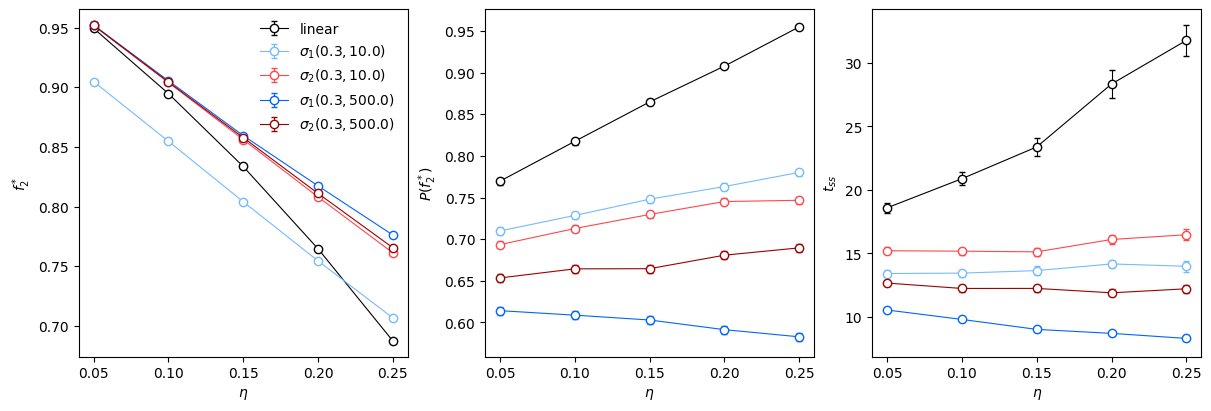

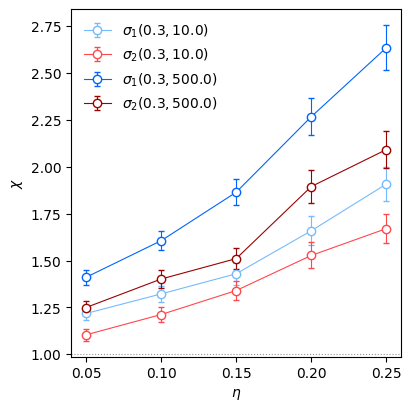

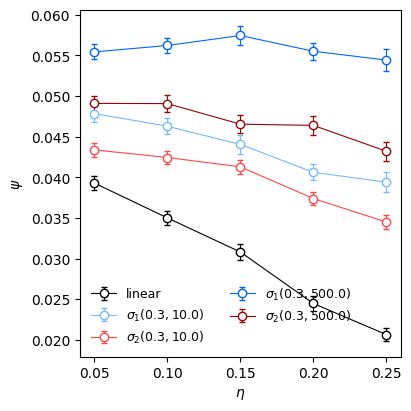

In [7]:
fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
figCF, axCF = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
figProd, axProd = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)

# let's label the noise with eta instead of sigma
ax[0].set(xlabel='$\eta$', ylabel='$f_2^*$')
ax[1].set(xlabel='$\eta$', ylabel='$P(f_2^*)$')
ax[2].set(xlabel='$\eta$', ylabel=r'$t_{ss}$')
axCF.set(xlabel='$\eta$', ylabel='$\chi$')
axProd.set(xlabel='$\eta$', ylabel='$\psi$')

species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")


ebars = True
# jitterer = np.linspace(-0.015,0.015, len(ci_kwargs_list))
jitterer = np.linspace(-0.0,0.0, len(ci_kwargs_list))
# ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
color_seq = ['k', 'xkcd:sky blue', 'xkcd:light red', 'xkcd:bright blue', 'xkcd:deep red']
if ebars:
    for ci_kwargs, cilabel, c, jit in zip(ci_kwargs_list, species, color_seq, jitterer):
        ax[0].errorbar(noises+jit, costFuncData[tuple(ci_kwargs)]['f2winVal'], costFuncData[tuple(ci_kwargs)]['f2winValerr'], lw=0.8, marker='o', color=c, mfc='w', label=cilabel, capsize=2.0)
        ax[1].errorbar(noises+jit, costFuncData[tuple(ci_kwargs)]['probf2winVal'], costFuncData[tuple(ci_kwargs)]['probf2winValerr'], lw=0.8, marker='o', color=c, mfc='w', capsize=2.0)
        ax[2].errorbar(noises+jit, costFuncData[tuple(ci_kwargs)]['tss'], costFuncData[tuple(ci_kwargs)]['tsserr'], lw=0.8, marker='o', color=c, mfc='w', capsize=2.0)
        # product of f2* and prob(f2*)
        # prod = np.array(costFuncData[tuple(ci_kwargs)]['f2winVal'])*np.array(costFuncData[tuple(ci_kwargs)]['probf2winVal'])
        # axProd.plot(ls+jit, prod, lw=0.8, marker='o', color=c, mfc='w', label=cilabel) # only the product of f2*probf2
        axProd.errorbar(noises+jit, costFuncData[tuple(ci_kwargs)]['CF'], costFuncData[tuple(ci_kwargs)]['CFerr'], lw=0.8, marker='o', color=c, mfc='w', label=cilabel, capsize=2.0) # the psi function
else:
    for ci_kwargs, cilabel, c in zip(ci_kwargs_list, species, color_seq):
        ax[0].plot(noises, costFuncData[tuple(ci_kwargs)]['f2winVal'], lw=0.8, marker='o', color=c, mfc='w', label=cilabel)
        ax[1].plot(noises, costFuncData[tuple(ci_kwargs)]['probf2winVal'], lw=0.8, marker='o', color=c, mfc='w')
        ax[2].plot(noises, costFuncData[tuple(ci_kwargs)]['tss'], lw=0.8, marker='o', color=c, mfc='w')
ax[0].legend(frameon=False)
axProd.legend(frameon=False, fontsize=9, ncol=2)


# lets call the cost function with the greek letter psi, and the ratio with chi
# jitterer = np.linspace(-0.01,0.01, len(ci_kwargs_list[1:]))
jitterer = np.linspace(-0.0,0.0, len(ci_kwargs_list[1:]))
psiLin, psiLinerr = np.array(costFuncData[(0, )]['CF']), np.array(costFuncData[(0, )]['CFerr'])
for i,(ci_kwargs,cilabel,c,jit) in enumerate(zip(ci_kwargs_list[1:],species[1:],color_seq[1:], jitterer)):
    psiCI, psiCIerr = np.array(costFuncData[tuple(ci_kwargs)]['CF']), np.array(costFuncData[tuple(ci_kwargs)]['CFerr'])
    chi = psiCI/psiLin
    chierr = (1/psiLin)*np.sqrt(psiCIerr**2 + (chi*psiLinerr)**2)
    if ebars:
        axCF.errorbar(noises+jit, chi, chierr, marker='o', mfc='w', color=c, capsize=2.0, lw=0.8, label=cilabel) # to use the standard color sequence: color=f'C{i+1}',
    else:
        axCF.plot(noises, chi, marker='o', mfc='w', color=c, lw=0.8)

axCF.axhline(1.0, 0, 1, ls=':', lw=0.8, color='xkcd:grey')
axCF.legend(frameon=False)


fig.savefig(f'cost_func_data_qs_{qchain}_noiseType_{noiseType}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}{ci_indep_q_label}.png')
figCF.savefig(f'chi_pis_qs_{qchain}_noiseType_{noiseType}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}{ci_indep_q_label}.png')
figProd.savefig(f'psi_pis_qs_{qchain}_noiseType_{noiseType}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}{ci_indep_q_label}.png')